# 82 Octet Binary Dataset

In [18]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
octet = pd.read_csv('octet.csv')
octet_selected = octet[['Delta E', 'rp(A)', 'rp(B)', 'rs(A)']]
# octet_selected['sigma'] = octet_selected['rp(A)']-octet_selected['rp(B)']
octet_sel = pd.DataFrame()
octet_sel.loc[:, 'sigma'] = octet_selected['rp(A)']-octet_selected['rp(B)']
octet_selected = pd.concat([octet_sel, octet_selected], axis=1)
# octet_selected = octet_selected.to_numpy()

In [20]:
octet_selected.loc[(octet_selected['sigma']>=0.91) & (octet_selected['rs(A)'] >=1.22), 'RS_ZB'] = 1 
octet_selected.loc[(octet_selected['sigma']<=-0.91) & (octet_selected['rs(A)'] >=1.22), 'RS_ZB'] = 1 
octet_selected.loc[(octet_selected['sigma']<=1.16) & (octet_selected['sigma']>=-1.16) & (octet_selected['rs(A)'] <=1.27), 'RS_ZB'] = -1 
octet_selected.loc[octet_selected['RS_ZB'].isnull(), 'RS_ZB'] = 0

octet_selected.loc[(octet_selected['sigma']>=0.91), 'sigma>0.91'] = 1
octet_selected.loc[octet_selected['sigma>0.91'].isnull(), 'sigma>0.91'] = 0

octet_selected.loc[(octet_selected['sigma']<=-0.91), 'sigma<-0.91'] = 1 
octet_selected.loc[octet_selected['sigma<-0.91'].isnull(), 'sigma<-0.91'] = 0

octet_selected.loc[(octet_selected['rs(A)']>=1.22), 'rs>1.22'] = 1 
octet_selected.loc[octet_selected['rs>1.22'].isnull(), 'rs>1.22'] = 0

octet_selected.loc[(octet_selected['sigma']<=1.16), 'sigma<1.16'] = 1 
octet_selected.loc[octet_selected['sigma<1.16'].isnull(), 'sigma<1.16'] = 0

octet_selected.loc[(octet_selected['sigma']>=-1.16), 'sigma>-1.16'] = 1 
octet_selected.loc[octet_selected['sigma>-1.16'].isnull(), 'sigma>-1.16'] = 0

octet_selected.loc[(octet_selected['rs(A)']<=1.27), 'rs<1.27'] = 1 
octet_selected.loc[octet_selected['rs<1.27'].isnull(), 'rs<1.27'] = 0

# second_layer_data = octet_selected[['sigma>0.91', 'sigma<-0.91', 'sigma<1.16', 'sigma>-1.16', 'rs>1.22','rs<1.27', 'RS_ZB']]

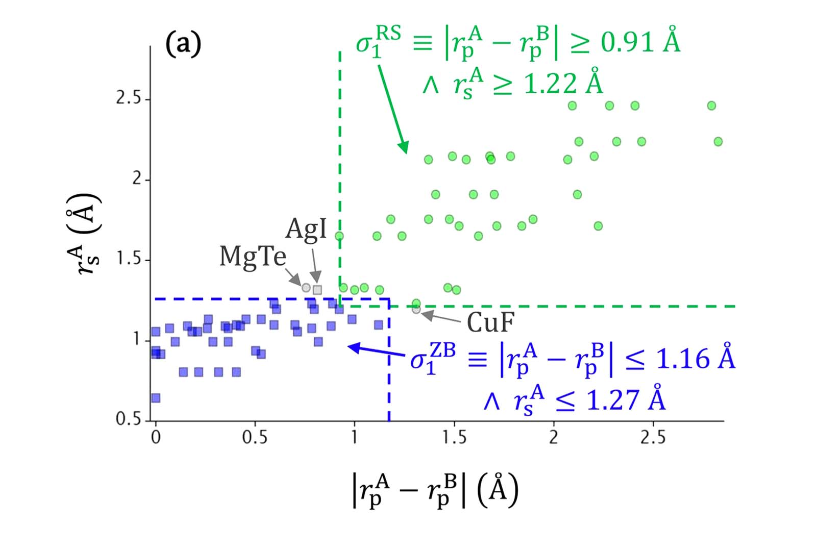

In [21]:
from IPython import display
display.Image("OctetBinaryPlot.png")

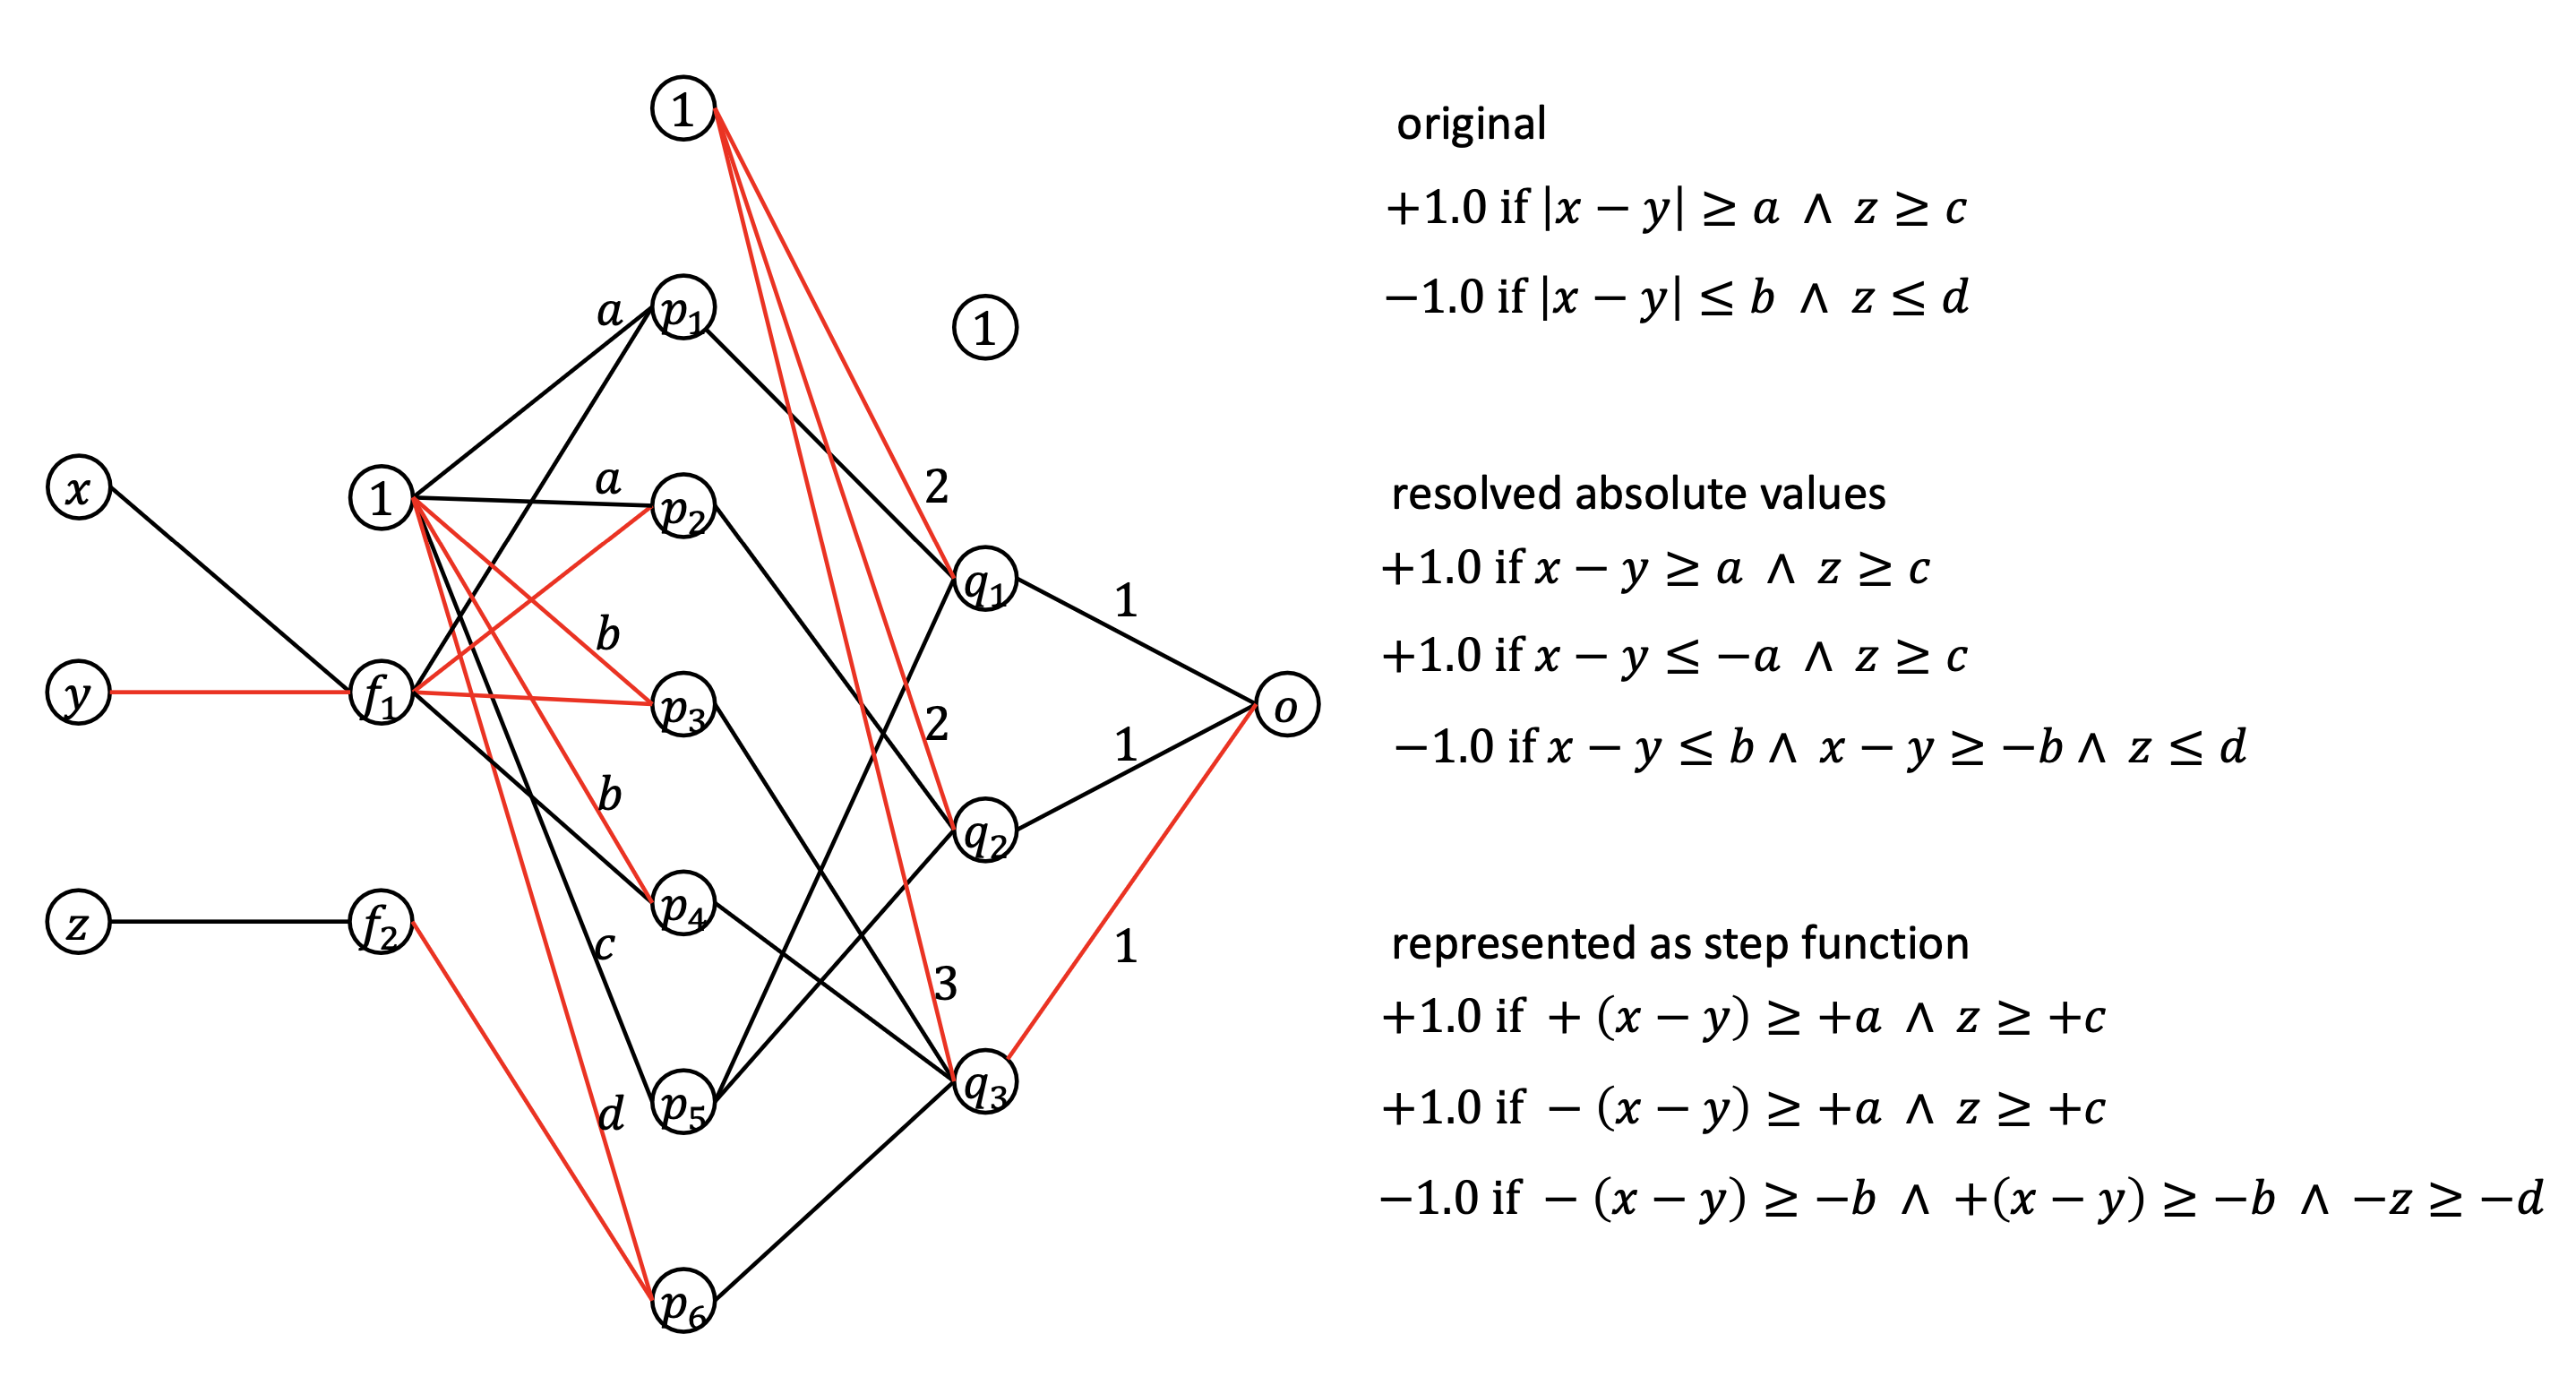

In [22]:
from IPython import display
display.Image("OctetBinary.png")

# Loading Dataset and Transform to Tensor

In [23]:
class OctetBinary(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.n_samples = X.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    

X = octet_selected[['sigma>0.91', 'sigma<-0.91', 'sigma<1.16', 'sigma>-1.16', 'rs>1.22','rs<1.27']].to_numpy()
# y = octet_selected['RS_ZB'].to_numpy()
y = octet_selected['Delta E'].to_numpy()

# RNG = np.random.default_rng(seed=0)
# train_ind = RNG.choice(len(X), size=int(len(X)*1), replace=True)
# test_ind = np.setdiff1d(np.array(range(len(X))), train_ind)
# X_train, X_test, y_train, y_test = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
    
dataset = OctetBinary(X, y)
dataloader = DataLoader(dataset=dataset, batch_size=int(1*len(X)), shuffle=True)

# Creating the NN Model

In [24]:
class StepActivation(nn.Module):
    def forward(self, x):
        return torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.0))

class BinaryRounding(nn.Module):
    def forward(self, x):
        return torch.where(x >= 0.5, torch.tensor(1.0), torch.tensor(0.0))

class SigmoidMinusOneActivation(torch.nn.Module):
    def forward(self, x):
        return torch.sigmoid(x) - 1


class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bias=False):
        super(RegressionModel, self).__init__()
        self.bias = bias
        self.hidden = nn.Linear(input_size, hidden_size, bias=self.bias)
        self.output = nn.Linear(hidden_size, output_size, bias=False)
   
    def forward(self, x):
        x = x - 1
        x = self.hidden(x)
        # x = torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.0))
        x = torch.sigmoid(x)
        x = self.output(x)
        # x = torch.tanh(10*x)
        return x

    def l1_loss(self):
        l1_loss = 0.0
        for param in self.parameters():
            l1_loss += torch.sum(torch.abs(param))
        return self.alpha * l1_loss
    
    def binary_loss(self):
        binary_loss = 0.0
        w_ = []
        for name, param in self.named_parameters():
            if name == 'hidden.0.weight':
                w_.append(param.reshape(-1,1))
            
        for v in w_:
            for v_i in v:
                if torch.abs(v_i) < torch.abs(v_i-1):
                    b = 0
                else:
                    b = 1
                binary_loss += torch.sum(torch.tensor(b))
        return binary_loss
    
    
    def round_parameters(self, hidden=True, output=False):
        for name, param in self.named_parameters():
            if name != 'output.weight' and hidden:
                param.data = torch.where(param.data >= 0.5, torch.tensor(1.0), torch.tensor(0.0)) #BinaryRounding.forward(param.data).clone().detach().requires_grad_(True)
            if name == 'output.weight' and output:
                param.data = torch.where(param.data >= 0.0, torch.tensor(1.0), torch.tensor(-1.0))

    def absolute_weights(self):
        for name, param in self.named_parameters():
            if name != 'output.weight':
                param.data = torch.abs(param.data)

    
    def predict(self, input):
        self.eval()
        input = torch.tensor(input, dtype=torch.float32)

        with torch.no_grad():
            output = self.forward(input)

        self.train()
        
        return output.numpy()
    

# BaseLine Model

In [25]:
class BaseModel(nn.Module):
    def __init__(self, weights):
        super(BaseModel, self).__init__()
        self.weights = weights
        self.hidden = nn.Linear(3, 1, bias=False)
   
    def forward(self, x):
        x = x - 1
        x = torch.mm(x, self.weights)
        x = torch.sigmoid(x)
        x = self.hidden(x)
        return x
    
    def predict(self, input):
        self.eval()
        input = torch.tensor(input, dtype=torch.float32)

        with torch.no_grad():
            output = self.forward(input)

        self.train()
        
        return output.numpy()

Early stopping at Epoch 23574 due to small gradients.
0
Early stopping at Epoch 18204 due to small gradients.
Early stopping at Epoch 20772 due to small gradients.
Early stopping at Epoch 15093 due to small gradients.
Early stopping at Epoch 14358 due to small gradients.
Early stopping at Epoch 13967 due to small gradients.
5
Early stopping at Epoch 27326 due to small gradients.
Early stopping at Epoch 20795 due to small gradients.
Early stopping at Epoch 24435 due to small gradients.
Early stopping at Epoch 26536 due to small gradients.
hidden.weight Parameter containing:
tensor([[-0.5007, -0.3332,  1.0147]], requires_grad=True)
Mean of MSE of all Reps: 0.1138


Text(0, 0.5, '$\\Delta E$')

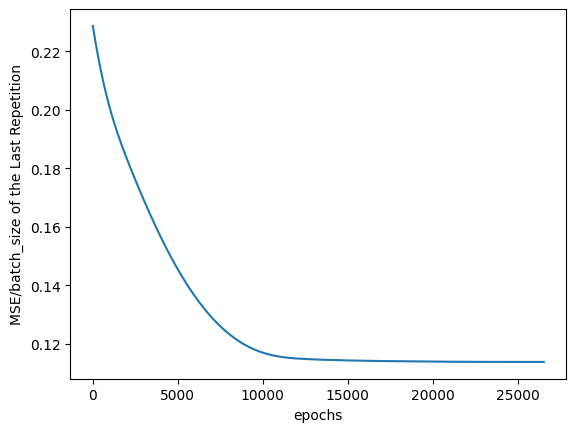

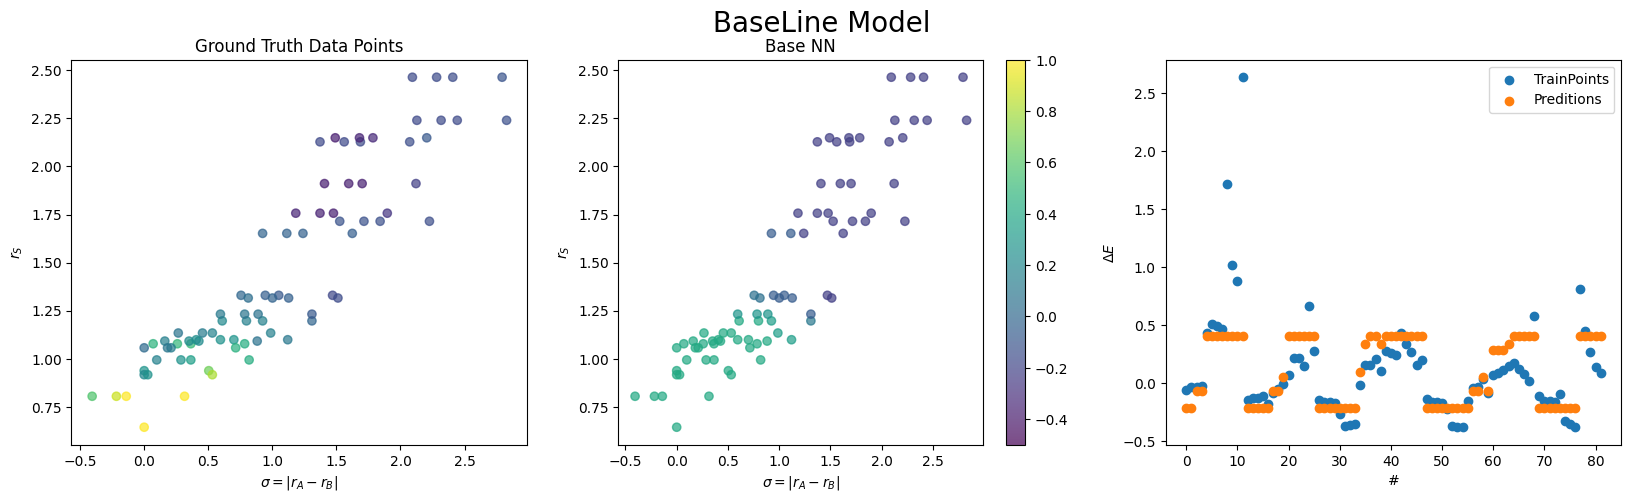

In [26]:
loss_criterion = nn.MSELoss()
num_epochs = 50000

# for name, param in model_base.named_parameters():
#     print(name, param)

mse_list_base = []
gradient_threshold = 0.00001
n_reps = 10
for reps in range(n_reps):
    average_epoch_loss_list_base = []
    weight = torch.tensor([[1,0,0,0,1,0],[0,1,0,0,1,0],[0,0,1,1,0,1]], dtype=torch.float32, requires_grad=False).T
    model_base = BaseModel(weights = weight)
    optimizer = torch.optim.Adam(model_base.parameters(), lr=0.0001)
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        gradient_norms = []
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad() 
            predictions = model_base.forward(batch_x)  
            mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
            total_loss = mse_loss  
            total_loss.backward()  
            optimizer.step() 
            epoch_loss += total_loss.item()
        for param in model_base.parameters():
            gradient_norms.append(torch.norm(param.grad).item())

        average_epoch_loss = epoch_loss / len(dataloader)
        average_epoch_loss_list_base.append(average_epoch_loss)

        if all(norm < gradient_threshold for norm in gradient_norms):
            print(f'Early stopping at Epoch {epoch + 1} due to small gradients.')
            break
    y_pred_base = model_base.predict(X)
    y_train = y.reshape(-1,1)
    mse_list_base.append(np.mean((y_train-y_pred_base)**2))
    if reps % 5 == 0:
        print(reps)

plt.plot(range(epoch+1), average_epoch_loss_list_base)
plt.xlabel('epochs')
plt.ylabel('MSE/batch_size of the Last Repetition')
plt.title('Training Trend of Last Repetition')
for name, param in model_base.named_parameters():
    print(name, param)


print(f'Mean of MSE of all Reps: {np.mean(mse_list_base):.4f}')

np.random.seed(19680801)
yaxis = [y_train,y_pred_base]
axs_title = ['Ground Truth Data Points', 'Base NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(' BaseLine Model ', fontsize=20)
for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'],octet_selected['rs(A)'], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-0.5, vmax=1)
    ax.set_title(axs_title[col])
    ax.set_xlabel('$\\sigma = |r_A - r_B|$')
    ax.set_ylabel('$r_S$')

fig.colorbar(pcm)
axs[2].scatter(range(len(y_train)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_pred_base)),y_pred_base, label='Preditions')
axs[2].legend()
axs[2].set_xlabel('#')
axs[2].set_ylabel('$\Delta E$')




# Scenario 0: Regular NN Training
1. Initialise the Weights
    
For each loop:

2. $y_{pred} = Model(X,W_t, \theta_t)$ (Froward Step)
3. $loss(y, y_{pred})$ 
4. $\nabla_{w_t} = \frac{\partial loss}{\partial W_t}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
5. $W_{t+1} = W_t + \eta \nabla_{w_t}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

Early stopping at Epoch 24087 due to small gradients.
0
Early stopping at Epoch 25028 due to small gradients.
Early stopping at Epoch 30054 due to small gradients.
Early stopping at Epoch 26603 due to small gradients.
Early stopping at Epoch 25337 due to small gradients.
Early stopping at Epoch 27730 due to small gradients.
5
Early stopping at Epoch 24515 due to small gradients.
Early stopping at Epoch 25258 due to small gradients.
Early stopping at Epoch 29456 due to small gradients.
Early stopping at Epoch 23134 due to small gradients.
hidden.weight Parameter containing:
tensor([[ 0.7889, -0.0979, -0.1610,  0.2064,  0.2124,  0.0023],
        [ 1.4303, -1.8141,  0.5104,  0.3522,  0.2955, -1.2867],
        [-0.5393,  1.8242,  1.2155,  0.3852, -0.9698, -0.6389]],
       requires_grad=True)
output.weight Parameter containing:
tensor([[ 1.2188, -1.1030,  1.5765]], requires_grad=True)
Mean of MSE of all Reps: 0.1103


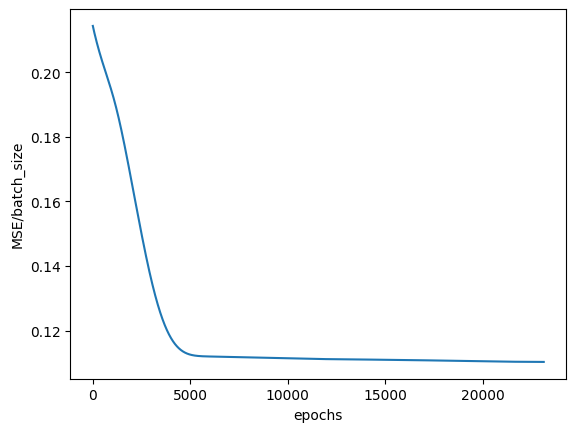

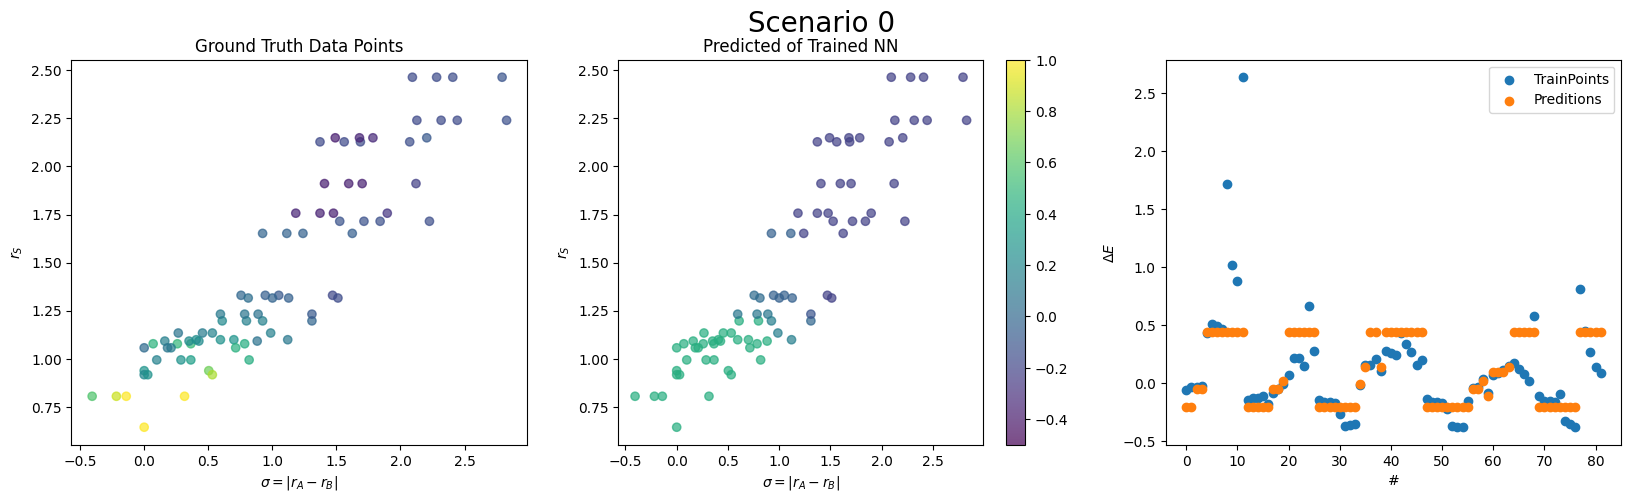

In [27]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
alpha = 0
num_epochs = 50000
n_reps = 10
gradient_threshold = 0.0001
mse_0_list = []
for reps in range(n_reps):
    model_0 = RegressionModel(input_size, hidden_size, output_size, bias=False)
    # for name, param in model_0.named_parameters():
    #     if name != 'output.weight':
    #         param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)
    # for name, param in model_0.named_parameters():
    #     print(name, param)

    optimizer = torch.optim.Adam(model_0.parameters(), lr=0.0001)
    average_epoch_loss_list_0 = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        gradient_norms = []
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad() 
            predictions = model_0.forward(batch_x)  
            mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
            binary_loss = model_0.binary_loss()
            total_loss = mse_loss + alpha*binary_loss 
            total_loss.backward()  
            optimizer.step() 
            epoch_loss += total_loss.item()

        for param in model_0.parameters():
            gradient_norms.append(torch.norm(param.grad).item())

        average_epoch_loss = epoch_loss / len(dataloader)
        average_epoch_loss_list_0.append(average_epoch_loss)

        if all(norm < gradient_threshold for norm in gradient_norms):
            print(f'Early stopping at Epoch {epoch + 1} due to small gradients.')
            break
    y_pred_0 = model_0.predict(X)
    y_train = y.reshape(-1,1)
    mse_0_list.append(np.mean((y_train-y_pred_0)**2))
    if reps % 5 == 0:
        print(reps)


plt.plot(range(epoch+1), average_epoch_loss_list_0)
plt.xlabel('epochs')
plt.ylabel('MSE/batch_size')
plt.title('Training Trend of Last Repetition')
for name, param in model_0.named_parameters():
    print(name, param)
y_pred_0 = model_0.predict(X)
y_train = y.reshape(-1,1)
mse_0 = np.mean((y_train-y_pred_0)**2)
# print(f'The MSE is {mse_0:.4f}')

np.random.seed(19680801)
yaxis = [y_train,y_pred_0]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(' Scenario 0 ', fontsize=20)
for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'],octet_selected['rs(A)'], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-0.5, vmax=1)
    ax.set_title(axs_title[col])
    ax.set_xlabel('$\\sigma = |r_A - r_B|$')
    ax.set_ylabel('$r_S$')

fig.colorbar(pcm)
axs[2].scatter(range(len(y_pred_0)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_pred_0)),y_pred_0, label='Preditions')
axs[2].legend()
axs[2].set_xlabel('#')
axs[2].set_ylabel('$\Delta E$')

print(f'Mean of MSE of all Reps: {np.mean(mse_0_list):.4f}')

# Scenario 1: Rounding the Weights After Each Training
1. Initialise the Weights
    
For each loop:

2. $y_{pred} = Model(X,W_t, \theta_t)$ (Froward Step)
3. $loss(y, y_{pred})$ 
4. $\nabla_{w_t} = \frac{\partial loss}{\partial W_t}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
5. $W_{t+1} = W_t + \eta \nabla_{w_t}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

6. $W = Binarise(W_{\tau})$ and $\theta = Sign(\theta_{\tau})$ 

Early stopping at Epoch 12757 due to small gradients.
Early stopping at Epoch 11162 due to small gradients.
Early stopping at Epoch 11975 due to small gradients.
Early stopping at Epoch 8246 due to small gradients.
Early stopping at Epoch 10979 due to small gradients.
Early stopping at Epoch 11107 due to small gradients.
Early stopping at Epoch 11505 due to small gradients.
Early stopping at Epoch 10940 due to small gradients.
Early stopping at Epoch 10705 due to small gradients.
Early stopping at Epoch 10971 due to small gradients.
hidden.weight Parameter containing:
tensor([[0., 0., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1.],
        [0., 1., 1., 0., 0., 0.]], requires_grad=True)
output.weight Parameter containing:
tensor([[-0.3401,  0.6372,  0.5458]], requires_grad=True)
The MSE is 0.1484
Mean of MSE of all Reps: 0.1749


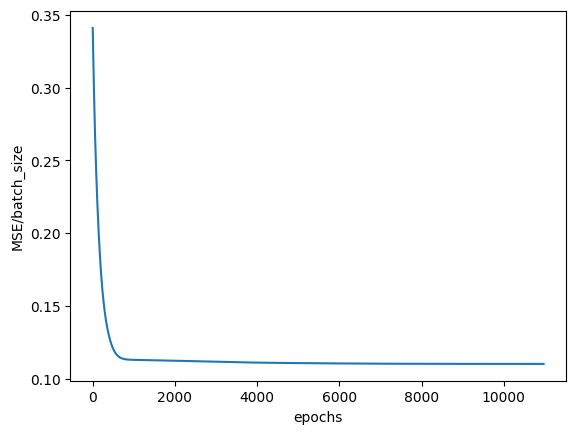

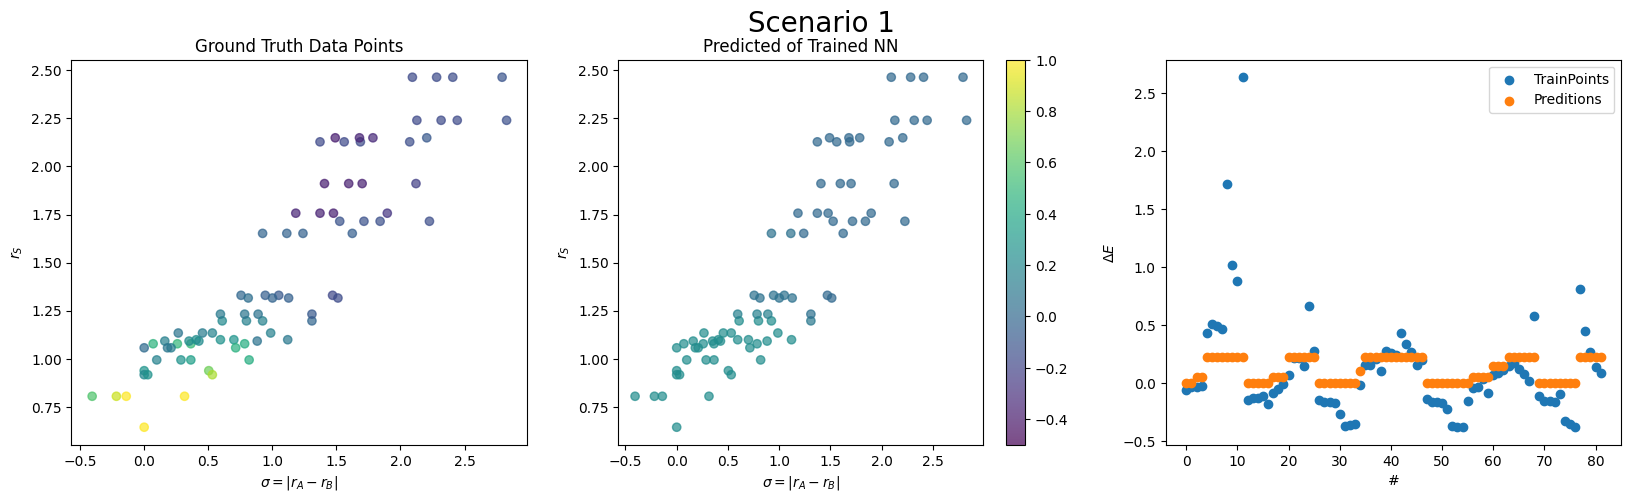

In [28]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
num_epochs = 50000
mse_1_list = []
gradient_threshold = 0.00001
n_reps = 10
for reps in range(n_reps):
    model_1 = RegressionModel(input_size, hidden_size, output_size, bias=False)
    # for name, param in model_1.named_parameters():
    #     print(name, param)

    optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
    average_epoch_loss_list_1 = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        gradient_norms = []
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad() 
            predictions = model_1.forward(batch_x)  
            mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
            total_loss = mse_loss
            total_loss.backward()  
            optimizer.step() 
            epoch_loss += total_loss.item()

        for param in model_1.parameters():
            gradient_norms.append(torch.norm(param.grad).item())

        average_epoch_loss = epoch_loss / len(dataloader)
        average_epoch_loss_list_1.append(average_epoch_loss)

        if all(norm < gradient_threshold for norm in gradient_norms):
            print(f'Early stopping at Epoch {epoch + 1} due to small gradients.')
            break

    model_1.round_parameters(hidden=True, output=False)
    y_pred_1 = model_1.predict(X)
    y_train = y.reshape(-1,1)
    mse_1_list.append(np.mean((y_train-y_pred_1)**2))

plt.plot(range(epoch+1), average_epoch_loss_list_1)
plt.xlabel('epochs')
plt.ylabel('MSE/batch_size')
plt.title('Training Trend of Last Repetition')
model_1.round_parameters(hidden=True, output=False)
for name, param in model_1.named_parameters():
    print(name, param)
y_pred_1 = model_1.predict(X)
y_train = y.reshape(-1,1)
mse_1 = np.mean((y_train-y_pred_1)**2)
print(f'The MSE is {mse_1:.4f}')

np.random.seed(19680801)
yaxis = [y_train,y_pred_1]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(' Scenario 1 ', fontsize=20)
for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'],octet_selected['rs(A)'], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-0.5, vmax=1)
    ax.set_title(axs_title[col])
    ax.set_xlabel('$\\sigma = |r_A - r_B|$')
    ax.set_ylabel('$r_S$')

fig.colorbar(pcm)
axs[2].scatter(range(len(y_pred_1)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_pred_1)),y_pred_1, label='Preditions')
axs[2].legend()
axs[2].set_xlabel('#')
axs[2].set_ylabel('$\Delta E$')

print(f'Mean of MSE of all Reps: {np.mean(mse_1_list):.4f}')

# Scenario 2: Rounding the Proposition Layer Weights in Each Training Loop before Forward Step
1. Initialise the Weights (Intentionally we choose random integers from -1 to 1 for hidden layer)

For each epoch:

2. $W_b = Binarise(W_t)$
3. $y_{pred} = Model(X,W_b, \theta_t)$ (Froward Step)
4. $loss(y, y_{pred})$ 
5. $\nabla_{w_b} = \frac{\partial loss}{\partial W_b}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
6. $W_{t+1} = W_b + \eta \nabla_{w_b}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

7. $W = Binarise(W_{\tau})$ and $\theta = Sign(\theta_{\tau})$ 

hidden.weight Parameter containing:
tensor([[0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], requires_grad=True)
output.weight Parameter containing:
tensor([[ 2.3507, -0.9181, -1.1155]], requires_grad=True)
The MSE is 0.1242
Mean of MSE of all Reps: 0.1344


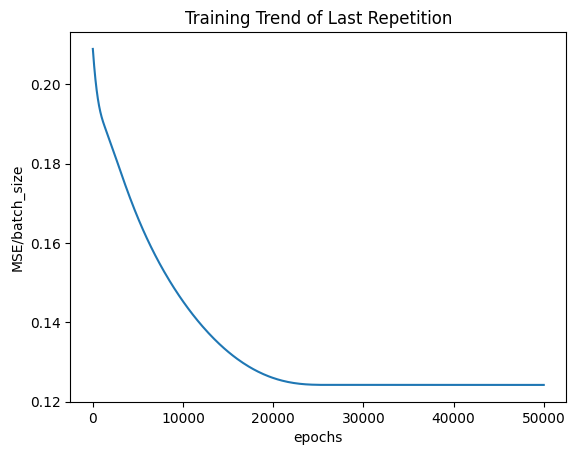

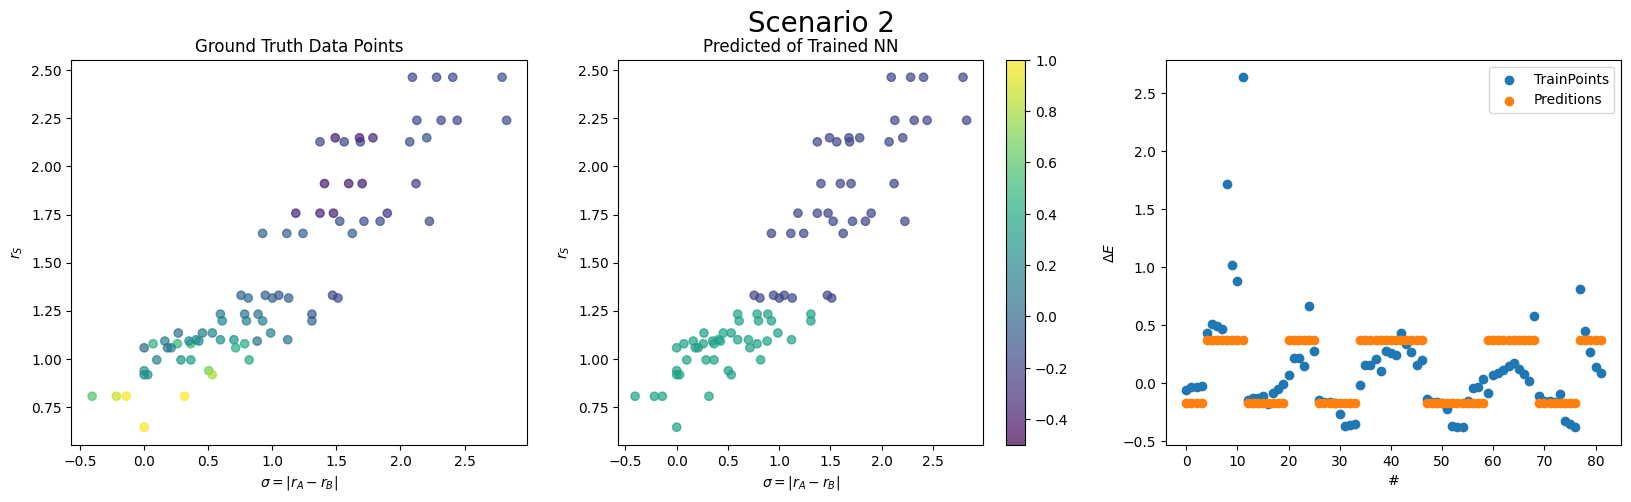

In [29]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
num_epochs = 50000
mse_2_list = []
gradient_threshold = 0.0001
n_reps = 10
for reps in range(n_reps):
    model_2 = RegressionModel(input_size, hidden_size, output_size, bias=False)
    for name, param in model_2.named_parameters():
        if name != 'output.weight':
            param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)

    optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0001)
    average_epoch_loss_list_2 = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        gradient_norms = []
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad() 
            for name, param in model_2.named_parameters():
                if name != 'output.weight': 
                    rounded_weights = torch.where(param >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
                    param.data = rounded_weights
                    
            predictions = model_2.forward(batch_x)  
            mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
            total_loss = mse_loss
            total_loss.backward()  
            optimizer.step() 
            epoch_loss += total_loss.item()
        for param in model_2.parameters():
            gradient_norms.append(torch.norm(param.grad).item())

        average_epoch_loss = epoch_loss / len(dataloader)
        average_epoch_loss_list_2.append(average_epoch_loss)

        if all(norm < gradient_threshold for norm in gradient_norms):
            print(f'Early stopping at Epoch {epoch + 1} due to small gradients.')
            break

    model_2.round_parameters(hidden=True, output=False)
    y_pred_2 = model_2.predict(X)
    y_train = y.reshape(-1,1)
    mse_2_list.append(np.mean((y_train-y_pred_2)**2))

plt.plot(range(epoch+1), average_epoch_loss_list_2)
plt.xlabel('epochs')
plt.ylabel('MSE/batch_size')
plt.title('Training Trend of Last Repetition')

model_2.round_parameters(hidden=True, output=False)
for name, param in model_2.named_parameters():
    print(name, param)
y_pred_2 = model_2.predict(X)
y_train = y.reshape(-1,1)
mse_2 = np.mean((y_train-y_pred_2)**2)
print(f'The MSE is {mse_2:.4f}')

np.random.seed(19680801)
yaxis = [y_train,y_pred_2]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(' Scenario 2 ', fontsize=20)
for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'],octet_selected['rs(A)'], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-0.5, vmax=1)
    ax.set_title(axs_title[col])
    ax.set_xlabel('$\\sigma = |r_A - r_B|$')
    ax.set_ylabel('$r_S$')

fig.colorbar(pcm)
axs[2].scatter(range(len(y_pred_2)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_pred_2)),y_pred_2, label='Preditions')
axs[2].legend()
axs[2].set_xlabel('#')
axs[2].set_ylabel('$\Delta E$')

print(f'Mean of MSE of all Reps: {np.mean(mse_2_list):.4f}')

# Scenario 3: Rounding the Proposition Layer Weights before Forward Step and Update the nonbinarized Weight
1- Initialise the Weights (Intentionally we choose random integers from -1 to 1 for hidden layer)

For each epoch:

2. Keeping $W_t, \theta_t$ 
3. $W_b = Binarise(W_t)$ 
4. $y_{pred} = Model(X,W_b, \theta_t)$ (Froward Step)
5. $loss(y, y_{pred})$ 
6. $\nabla_{w_b} = \frac{\partial loss}{\partial W_b}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
7. $W_{t+1} = W_t + \eta \nabla_{w_b}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

8. $W = Binarise(W_{\tau})$ and $\theta = Sign(\theta_{\tau})$ 

hidden.weight Parameter containing:
tensor([[1., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.]], requires_grad=True)
output.weight Parameter containing:
tensor([[-0.8438,  0.6592,  0.3561]], requires_grad=True)
The MSE is 0.1139
Mean of MSE of all Reps: 0.1139


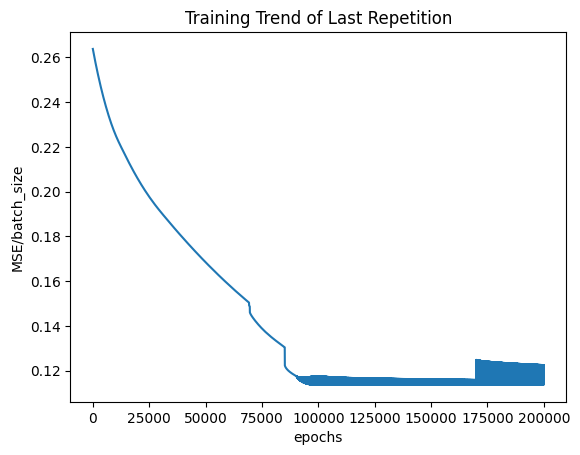

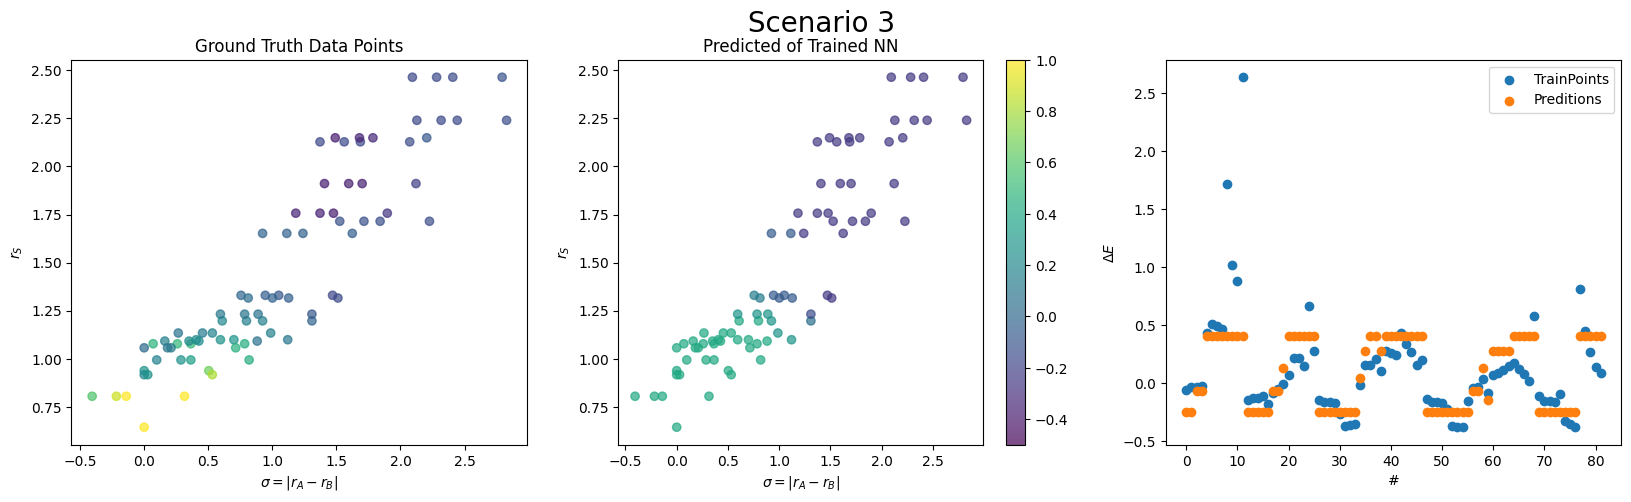

In [58]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
alpha = 0
num_epochs = 200000
mse_3_list = []
n_reps = 1
gradient_threshold = 0.001
for reps in range(n_reps):
    model_3 = RegressionModel(input_size, hidden_size, output_size, bias=False)
    for name, param in model_3.named_parameters():
        if name != 'output.weight':
            param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)
        # print(name, param)
    optimizer = torch.optim.Adam(model_3.parameters(), lr=0.00001)
    average_epoch_loss_list_3 = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        gradient_norms = []
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad() 

            for name, param in model_3.named_parameters():
                if name != 'output.weight':
                    unrounded_weights = param.detach()
                    rounded_weights = torch.where(param >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
                    param.data = rounded_weights
                    
            predictions = model_3.forward(batch_x)  
            mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
            total_loss = mse_loss 
            total_loss.backward()  

            for name, param in model_3.named_parameters():
                if name != 'output.weight': 
                    if param.grad is not None:
                        param.data = unrounded_weights

            optimizer.step() 
            epoch_loss += total_loss.item()
        for param in model_3.parameters():
            gradient_norms.append(torch.norm(param.grad).item())

        average_epoch_loss = epoch_loss / len(dataloader)
        average_epoch_loss_list_3.append(average_epoch_loss)

        if all(norm < gradient_threshold for norm in gradient_norms):
            print(f'Early stopping at Epoch {epoch + 1} due to small gradients.')
            break
        
    model_3.round_parameters(hidden=True, output=False)
    y_pred_3 = model_3.predict(X)
    y_train = y.reshape(-1,1)
    mse_3_list.append(np.mean((y_train-y_pred_3)**2))


plt.plot(range(epoch+1), average_epoch_loss_list_3)
plt.xlabel('epochs')
plt.ylabel('MSE/batch_size')
plt.title('Training Trend of Last Repetition')
model_3.round_parameters(hidden=True, output=False)
for name, param in model_3.named_parameters():
    print(name, param)
y_pred_3 = model_3.predict(X)
y_train = y.reshape(-1,1)
mse_3 = np.mean((y_train-y_pred_3)**2)
print(f'The MSE is {mse_3:.4f}')

np.random.seed(19680801)
# yaxis = [np.where(y_train>0.0, 1, -1),np.where(y_pred>0.0, 1, -1)]
yaxis = [y_train,y_pred_3]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(' Scenario 3 ', fontsize=20)
for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'],octet_selected['rs(A)'], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-0.5, vmax=1)
    ax.set_title(axs_title[col])
    ax.set_xlabel('$\\sigma = |r_A - r_B|$')
    ax.set_ylabel('$r_S$')

fig.colorbar(pcm)
axs[2].scatter(range(len(y_train)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_train)),y_pred_3, label='Preditions')
axs[2].legend()
axs[2].set_xlabel('#')
axs[2].set_ylabel('$\Delta E$')

print(f'Mean of MSE of all Reps: {np.mean(mse_3_list):.4f}')

# Scenario 4: Using Binary Penalty and Rounding the Weights After Each Training
1. Initialise the Weights
    
For each loop:

2. $y_{pred} = Model(X,W_t, \theta_t)$ (Froward Step)
3. $loss(y, y_{pred})+p(W_t)$ 
4. $\nabla_{w_t} = \frac{\partial loss}{\partial W_t}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
5. $W_{t+1} = W_t + \eta \nabla_{w_t}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

6. $W = Binarise(W_{\tau})$ and $\theta = Sign(\theta_{\tau})$ 

In [31]:
from sklearn.model_selection import KFold
input_size = 6
hidden_size = 3
output_size = 1
num_epochs = 50000
gradient_threshold = 0.00001
loss_criterion = nn.MSELoss()
kf = KFold(n_splits=4, shuffle=True, random_state=529)
alpha_range = np.logspace(-4, 0, num=10)
mse_list_per_alpha = []
for alpha in alpha_range:
    mse_list_per_fold = []
    for train_ind, val_ind in kf.split(X,y):
        model_ = RegressionModel(input_size, hidden_size, output_size, bias=False)
        optimizer = torch.optim.Adam(model_.parameters(), lr=0.001)
        dataset_ = OctetBinary(X[train_ind], y[train_ind])
        dataloader_ = DataLoader(dataset=dataset_, batch_size=int(len(X[train_ind])), shuffle=True)
        for epoch in range(num_epochs):
            gradient_norms = []
            gradient_threshold = 0.00001
            for batch_x, batch_y in dataloader_:
                optimizer.zero_grad() 
                predictions = model_.forward(batch_x)  
                mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
                binary_loss = model_.binary_loss()
                total_loss = mse_loss + alpha*binary_loss 
                total_loss.backward()  
                optimizer.step()
            for param in model_.parameters():
                gradient_norms.append(torch.norm(param.grad).item())
            if all(norm < gradient_threshold for norm in gradient_norms):
                print(f'Early stopping at Epoch {epoch + 1} due to small gradients.')
                break
        model_.round_parameters(hidden=True, output=False)
        y_pred_ = model_.predict(X[val_ind])
        y_valid = y[val_ind].reshape(-1,1)
        mse_list_per_fold.append(np.mean((y_valid-y_pred_)**2))
    mse_list_per_alpha.append(np.mean(mse_list_per_fold))


Early stopping at Epoch 10893 due to small gradients.
hidden.weight Parameter containing:
tensor([[0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0.]], requires_grad=True)
output.weight Parameter containing:
tensor([[ 0.6777,  0.9910, -0.8001]], requires_grad=True)
Mean of MSE of all Reps: 0.1414


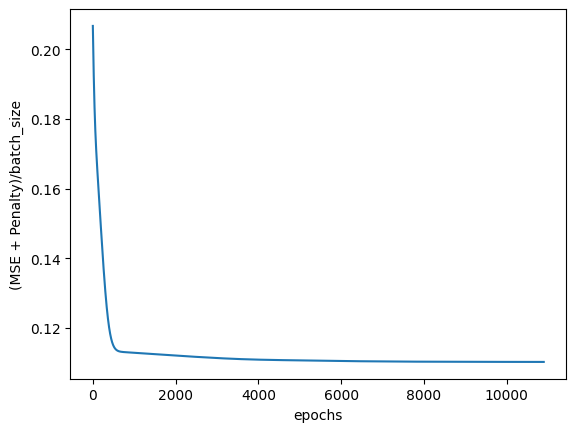

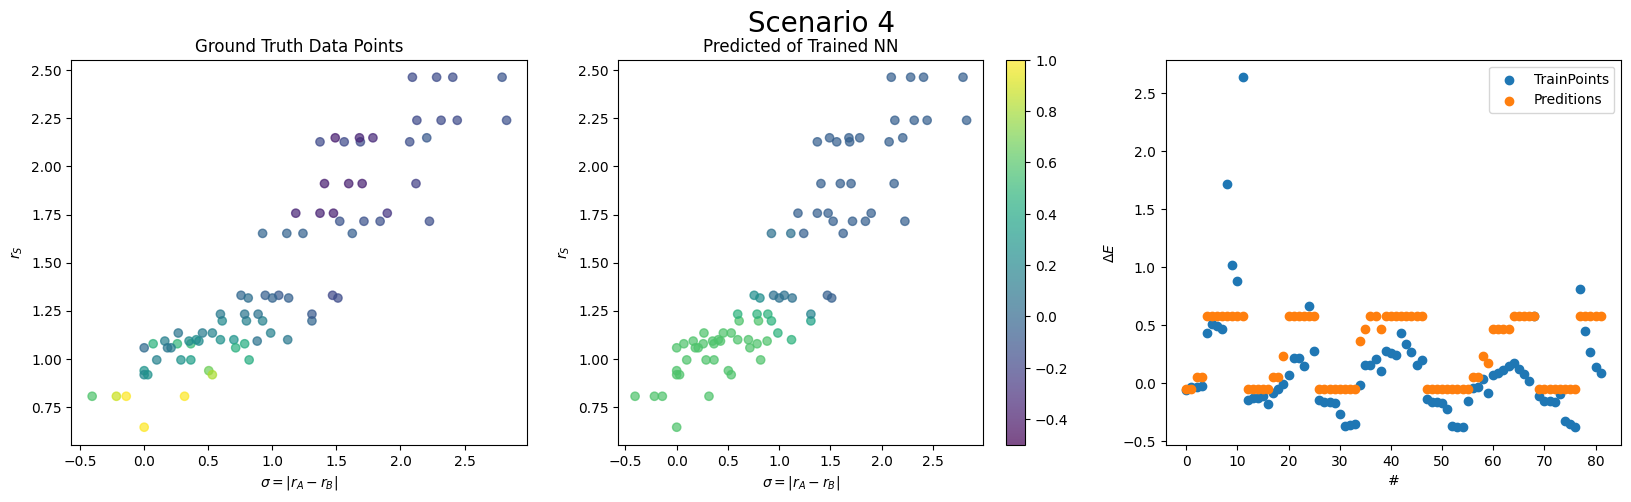

In [32]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
alpha = 0.01
num_epochs = 50000
mse_4_list = []
gradient_threshold = 0.00001
alpha = alpha_range[mse_list_per_alpha.index(min(mse_list_per_alpha))]
for reps in range(1):
    model_4 = RegressionModel(input_size, hidden_size, output_size, bias=False)
    # for name, param in model_4.named_parameters():
    #     print(name, param)

    optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)
    average_epoch_loss_list_4 = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        gradient_norms = []
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad() 
            predictions = model_4.forward(batch_x)  
            mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
            binary_loss = model_4.binary_loss()
            total_loss = mse_loss + alpha*binary_loss 
            total_loss.backward()  
            optimizer.step() 
            epoch_loss += total_loss.item()
        for param in model_4.parameters():
            gradient_norms.append(torch.norm(param.grad).item())

        average_epoch_loss = epoch_loss / len(dataloader)
        average_epoch_loss_list_4.append(average_epoch_loss)

        if all(norm < gradient_threshold for norm in gradient_norms):
            print(f'Early stopping at Epoch {epoch + 1} due to small gradients.')
            break

    model_4.round_parameters(hidden=True, output=False)
    y_pred_4 = model_4.predict(X)
    y_train = y.reshape(-1,1)
    mse_4_list.append(np.mean((y_train-y_pred_4)**2))
    

plt.plot(range(epoch+1), average_epoch_loss_list_4)
plt.xlabel('epochs')
plt.ylabel('(MSE + Penalty)/batch_size')
plt.title('Training Trend of Last Repetition')
for name, param in model_4.named_parameters():
    print(name, param)

np.random.seed(19680801)
yaxis = [y_train,y_pred_4]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(' Scenario 4 ', fontsize=20)
for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'],octet_selected['rs(A)'], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-0.5, vmax=1)
    ax.set_title(axs_title[col])
    ax.set_xlabel('$\\sigma = |r_A - r_B|$')
    ax.set_ylabel('$r_S$')

fig.colorbar(pcm)
axs[2].scatter(range(len(y_train)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_pred_4)),y_pred_4, label='Preditions')
axs[2].legend()
axs[2].set_xlabel('#')
axs[2].set_ylabel('$\Delta E$')

print(f'Mean of MSE of all Reps: {np.mean(mse_4_list):.4f}')

# Scenario 5: Using Binary Penalty and Rounding the Proposition Layer Weights before Forward Step and Update the nonbinarized Weight
1. Initialise the Weights
    
For each loop:

2. Keeping $W_t, \theta_t$ 
3. $W_b = Binarise(W_t)$ 
4. $y_{pred} = Model(X,W_b, \theta_t)$ (Froward Step)
5. $loss(y, y_{pred})+p(W_t)$ 
6. $\nabla_{w_b} = \frac{\partial loss}{\partial W_b}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
7. $W_{t+1} = W_t + \eta \nabla_{w_b}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

6. $W = Binarise(W_{\tau})$ and $\theta = Sign(\theta_{\tau})$ 

In [40]:
from sklearn.model_selection import KFold
input_size = 6
hidden_size = 3
output_size = 1
num_epochs = 50000
gradient_threshold = 0.00001
loss_criterion = nn.MSELoss()
kf = KFold(n_splits=4, shuffle=True, random_state=529)
alpha_range = np.logspace(-4, 0, num=10)
mse_list_per_alpha = []
for alpha in alpha_range:
    mse_list_per_fold = []
    for train_ind, val_ind in kf.split(X,y):
        model_ = RegressionModel(input_size, hidden_size, output_size, bias=False)
        for name, param in model_.named_parameters():
            if name != 'output.weight':
                param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)
        optimizer = torch.optim.Adam(model_.parameters(), lr=0.001)
        dataset_ = OctetBinary(X, y)
        dataloader_ = DataLoader(dataset=dataset_, batch_size=int(len(X)), shuffle=True)
        for epoch in range(num_epochs):
            gradient_norms = []
            gradient_threshold = 0.00001
            for batch_x, batch_y in dataloader_:
                optimizer.zero_grad()
                for name, param in model_.named_parameters():
                        if name != 'output.weight':
                            unrounded_weights = param.detach()
                            rounded_weights = torch.where(param >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
                            param.data = rounded_weights
                predictions = model_.forward(batch_x)
                mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
                binary_loss = model_.binary_loss()
                total_loss = mse_loss + alpha*binary_loss 
                total_loss.backward()

                for name, param in model_.named_parameters():
                    if name != 'output.weight': 
                        if param.grad is not None:
                            param.data = unrounded_weights
                optimizer.step()

            for param in model_.parameters():
                gradient_norms.append(torch.norm(param.grad).item())

            if all(norm < gradient_threshold for norm in gradient_norms):
                print(f'Early stopping at Epoch {epoch + 1} due to small gradients.')
                break
        model_.round_parameters(hidden=True, output=False)
        y_pred_ = model_.predict(X[val_ind])
        y_valid = y[val_ind].reshape(-1,1)
        mse_list_per_fold.append(np.mean((y_valid-y_pred_)**2))
    mse_list_per_alpha.append(np.mean(mse_list_per_fold))


hidden.weight Parameter containing:
tensor([[1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1.]], requires_grad=True)
output.weight Parameter containing:
tensor([[-0.6553,  0.6021,  0.7021]], requires_grad=True)
The MSE is 0.1140
Mean of MSE of all Reps: 0.1145


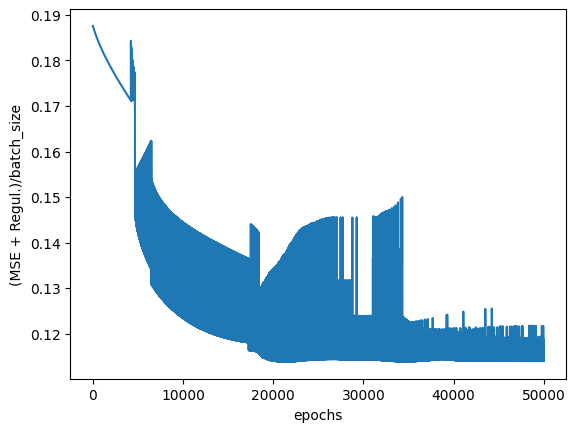

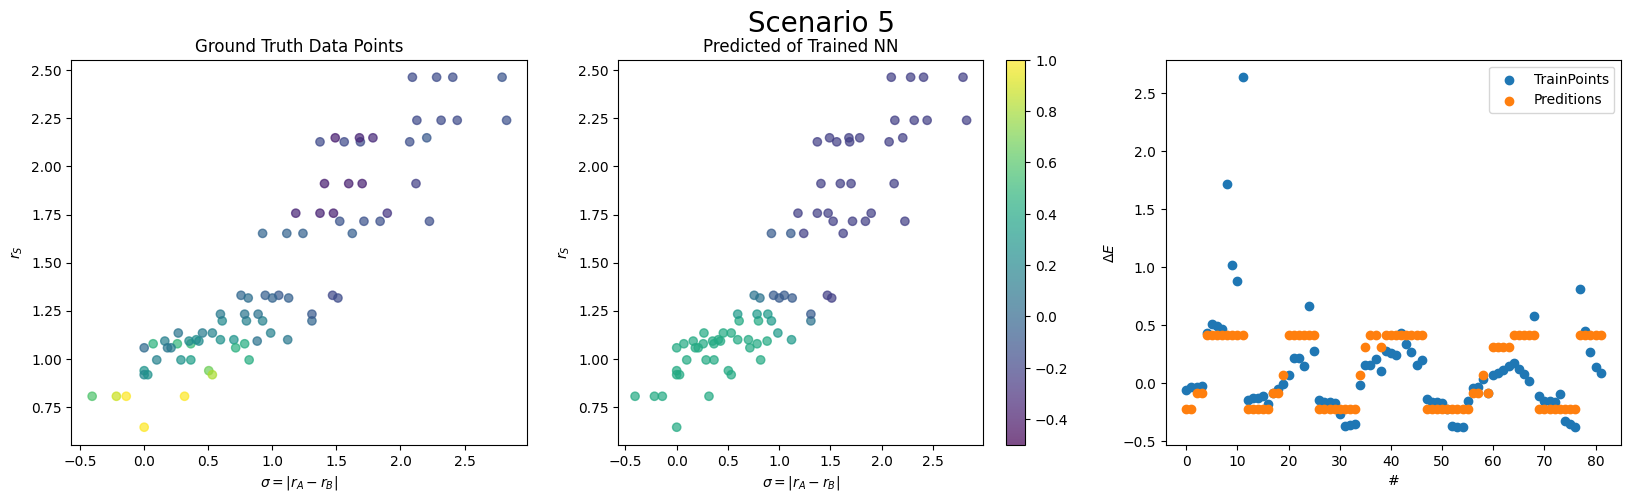

In [44]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
alpha = 0.001
num_epochs = 50000
mse_5_list = []
gradient_threshold = 0.0001
alpha_2 = alpha_range[mse_list_per_alpha.index(min(mse_list_per_alpha))]
n_reps = 10
for reps in range(n_reps):
    model_5 = RegressionModel(input_size, hidden_size, output_size, bias=False)
    for name, param in model_5.named_parameters():
        if name != 'output.weight':
            param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)
        # print(name, param)
    optimizer = torch.optim.Adam(model_5.parameters(), lr=0.0001)
    average_epoch_loss_list_5 = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        gradient_norms = []
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad() 

            for name, param in model_5.named_parameters():
                if name != 'output.weight':
                    unrounded_weights = param.detach()
                    rounded_weights = torch.where(param >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
                    param.data = rounded_weights
                    
            predictions = model_5.forward(batch_x)  
            mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
            binary_loss = model_5.binary_loss()
            total_loss = mse_loss + alpha_2*binary_loss 
            total_loss.backward()  

            for name, param in model_5.named_parameters():
                if name != 'output.weight': 
                    if param.grad is not None:
                        param.data = unrounded_weights

            optimizer.step() 
            epoch_loss += total_loss.item()

        for param in model_5.parameters():
            gradient_norms.append(torch.norm(param.grad).item())

        average_epoch_loss = epoch_loss / len(dataloader)
        average_epoch_loss_list_5.append(average_epoch_loss)

        if all(norm < gradient_threshold for norm in gradient_norms):
            print(f'Early stopping at Epoch {epoch + 1} due to small gradients.')
            break

    model_5.round_parameters(hidden=True, output=False)
    y_pred_5 = model_5.predict(X)
    y_train = y.reshape(-1,1)
    mse_5_list.append(np.mean((y_train-y_pred_5)**2))


plt.plot(range(epoch+1), average_epoch_loss_list_5)
plt.xlabel('epochs')
plt.ylabel('(MSE + Regul.)/batch_size')
plt.title('Training Trend of Last Repetition')
model_5.round_parameters(hidden=True, output=False)
for name, param in model_5.named_parameters():
    print(name, param)
y_pred_5 = model_5.predict(X)
y_train = y.reshape(-1,1)
mse_5 = np.mean((y_train-y_pred_5)**2)
print(f'The MSE is {mse_5:.4f}')

np.random.seed(19680801)
yaxis = [y_train,y_pred_5]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(' Scenario 5 ', fontsize=20)
for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'],octet_selected['rs(A)'], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-0.5, vmax=1)
    ax.set_title(axs_title[col])
    ax.set_xlabel('$\\sigma = |r_A - r_B|$')
    ax.set_ylabel('$r_S$')

fig.colorbar(pcm)
axs[2].scatter(range(len(y_train)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_train)),y_pred_5, label='Preditions')
axs[2].legend()
axs[2].set_xlabel('#')
axs[2].set_ylabel('$\Delta E$')

print(f'Mean of MSE of all Reps: {np.mean(mse_5_list):.4f}')

In [45]:
print(f'Mean of MSE for all Repetitions = {n_reps} is:')
print()
print(f'BaseLine : {np.mean(mse_list_base):.4f}')
print(f'Scenario 0 (Regular Backpro.): {np.mean(mse_0_list):.4f}')
print(f'Scenario 1 (Regular Backpro. + Binarising the Trained NN): {np.mean(mse_1_list):.4f}')
print(f'Scenario 2 (Binarising before Forward Step + Updating the Binarised W + Binarising the Trained NN): {np.mean(mse_2_list):.4f}')
print(f'Scenario 3 (Binarising before Forward Step + Updating the non-Binarised W + Binarising the Trained NN): {np.mean(mse_3_list):.4f}')
print(f'Scenario 4 (Regular Backpro. + Applying the Binary Penalty Term + Binarising the Trained NN): {np.mean(mse_4_list):.4f}')
print(f'Scenario 5 (Scenario 3 + Applying the Binary Penalty): {np.mean(mse_5_list):.4f}')


Mean of MSE for all Repetitions = 10 is:

BaseLine : 0.1138
Scenario 0 (Regular Backpro.): 0.1103
Scenario 1 (Regular Backpro. + Binarising the Trained NN): 0.1749
Scenario 2 (Binarising before Forward Step + Updating the Binarised W + Binarising the Trained NN): 0.1344
Scenario 3 (Binarising before Forward Step + Updating the non-Binarised W + Binarising the Trained NN): 0.1168
Scenario 4 (Regular Backpro. + Applying the Binary Penalty Term + Binarising the Trained NN): 0.1414
Scenario 5 (Scenario 3 + Applying the Binary Penalty): 0.1145


# Scenario --: Using SignSwish Activation

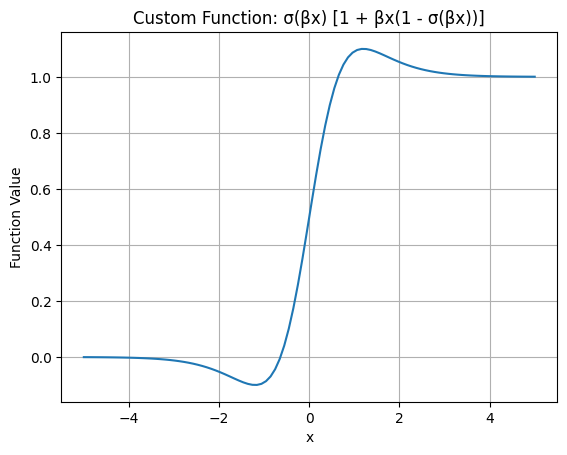

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z, alpha):
    return 1 / (1 + np.exp(-alpha*z))

def SignSwish(x, beta, alpha):
    z = beta * x
    return sigmoid(z, alpha) * (1 + z * (1 - sigmoid(z,alpha)))


x_values = np.linspace(-5, 5, 100)  
y_values = [SignSwish(x, beta=2, alpha=1) for x in x_values]

# Create the plot
plt.plot(x_values, y_values)
plt.title('Custom Function: σ(βx) [1 + βx(1 - σ(βx))]')
plt.xlabel('x')
plt.ylabel('Function Value')

# Show the plot
plt.grid(True)
plt.show()


In [37]:
def SSwish(x, beta, alpha):
    z = beta * x
    return torch.sigmoid(alpha*z) * (1 + z * (1 - torch.sigmoid(alpha*z)))

    